In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [2]:
# # Informações de conexão
# db_params = {
#   'user': 'postgres',
#   'password': 'postgres',
#   'host': 'localhost',
#   'dbname': 'GOALS',
# }

# # Conecta ao PostgreSQL
# conn = psycopg2.connect(**db_params)

# # Cria um cursor para executar comandos SQL
# cursor = conn.cursor()

# # Query Historico
# query = """SELECT * FROM futebol.match_history"""
# historico = pd.read_sql_query(query, conn)

In [3]:
historico = pd.read_excel('datasets/xlsx/historico.xlsx', index_col= 0)

In [4]:
historico = historico[(historico['season'] < 2023)]

In [5]:
gf_summary = historico.groupby(['comp'])['gf'].describe()

In [6]:
gf_summary.index

Index(['Brasileirao', 'Bundesliga', 'Premier League', 'Serie A'], dtype='object', name='comp')

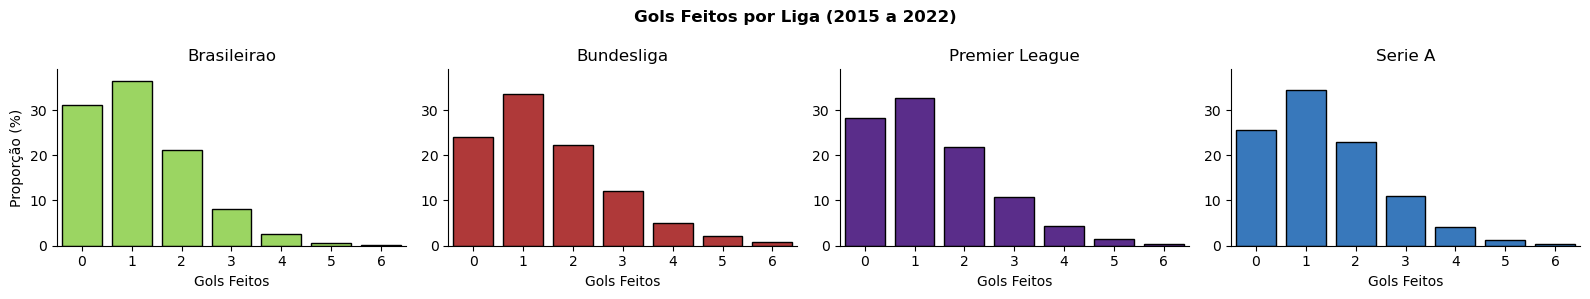

In [7]:
# Quantidade de ligas e suas cores
n_leagues = len(gf_summary.index)
colors_league = ['#9BE84F', '#C32525', '#591D99', '#2277D1']

# Gols feitos por ligas
fig, axes = plt.subplots(1, n_leagues, figsize= (16, 3))

for i, league in zip(range(n_leagues), gf_summary.index):
  sns.countplot(historico[historico['comp'] == league], x='gf', 
                stat= 'percent', ax= axes[i], color= colors_league[i], edgecolor= 'black')
  axes[i].set_ylim(0, 39)
  axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel("Gols Feitos")
  axes[i].set_title(league)
  if i > 0: 
    axes[i].set_ylabel("")

axes[0].set_ylabel("Proporção (%)")
plt.suptitle("Gols Feitos por Liga (2015 a 2022)", fontweight= 'bold')
plt.tight_layout()
plt.savefig('figures/analysis/gols-liga.png')
plt.show()


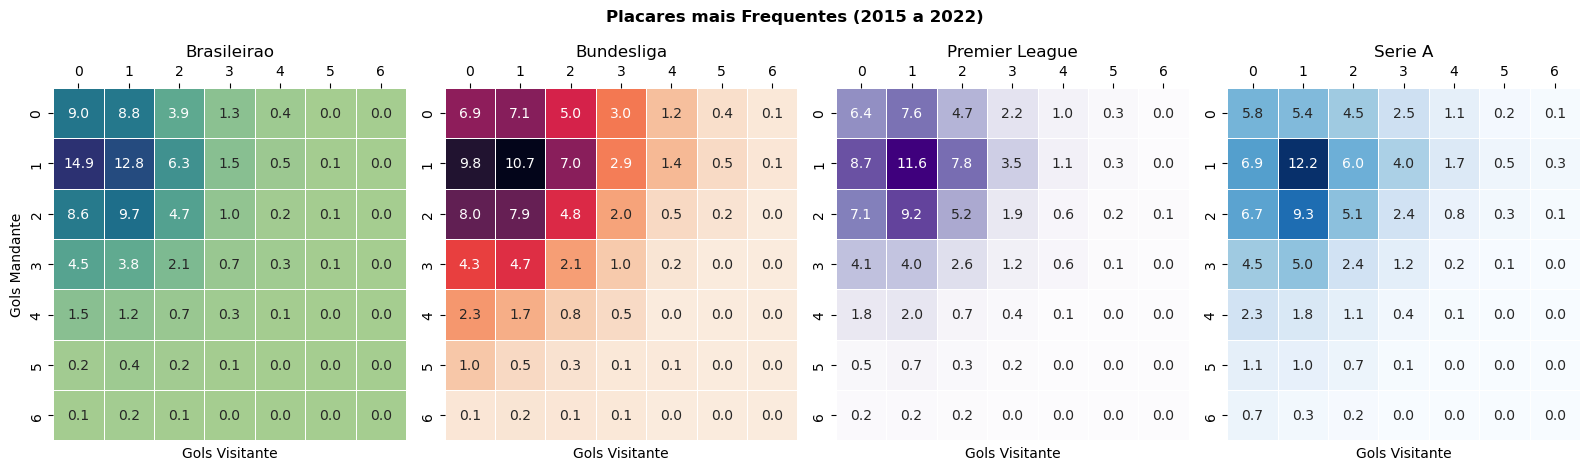

In [8]:
# Tabela de placares para cada liga
placares = []
for league in historico['comp'].unique():
  df = historico[historico['comp'] == league]
  df = df[df['venue'] == 'Home']
  df = pd.crosstab(df['gf'], df['ga'])
  df = (df/df.sum().sum())*100
  df = df.loc[:, df.columns <= 6]
  df = df.loc[df.index <= 6]
  placares.append(df)

# Cores das ligas
cores_cont = ['crest', 'rocket_r', 'Purples', 'Blues']

# Heatmap
fig, axes = plt.subplots(1, len(placares), figsize= (16, 5))
for i, league in zip(range(n_leagues), gf_summary.index):
  sns.heatmap(placares[i], annot=True, fmt='.1f', cmap= cores_cont[i], linewidth=.5, cbar= False, square= True, ax= axes[i])
  axes[i].xaxis.tick_top()
  axes[i].yaxis.tick_left()
  axes[i].set_xlabel("Gols Visitante")
  axes[i].set_ylabel("Gols Mandante")
  axes[i].set_title(league)
  if i > 0: 
    axes[i].set_ylabel("")

plt.suptitle("Placares mais Frequentes (2015 a 2022)", fontweight= 'bold')
plt.tight_layout()
plt.savefig('figures/analysis/placar-liga.png')
plt.show()

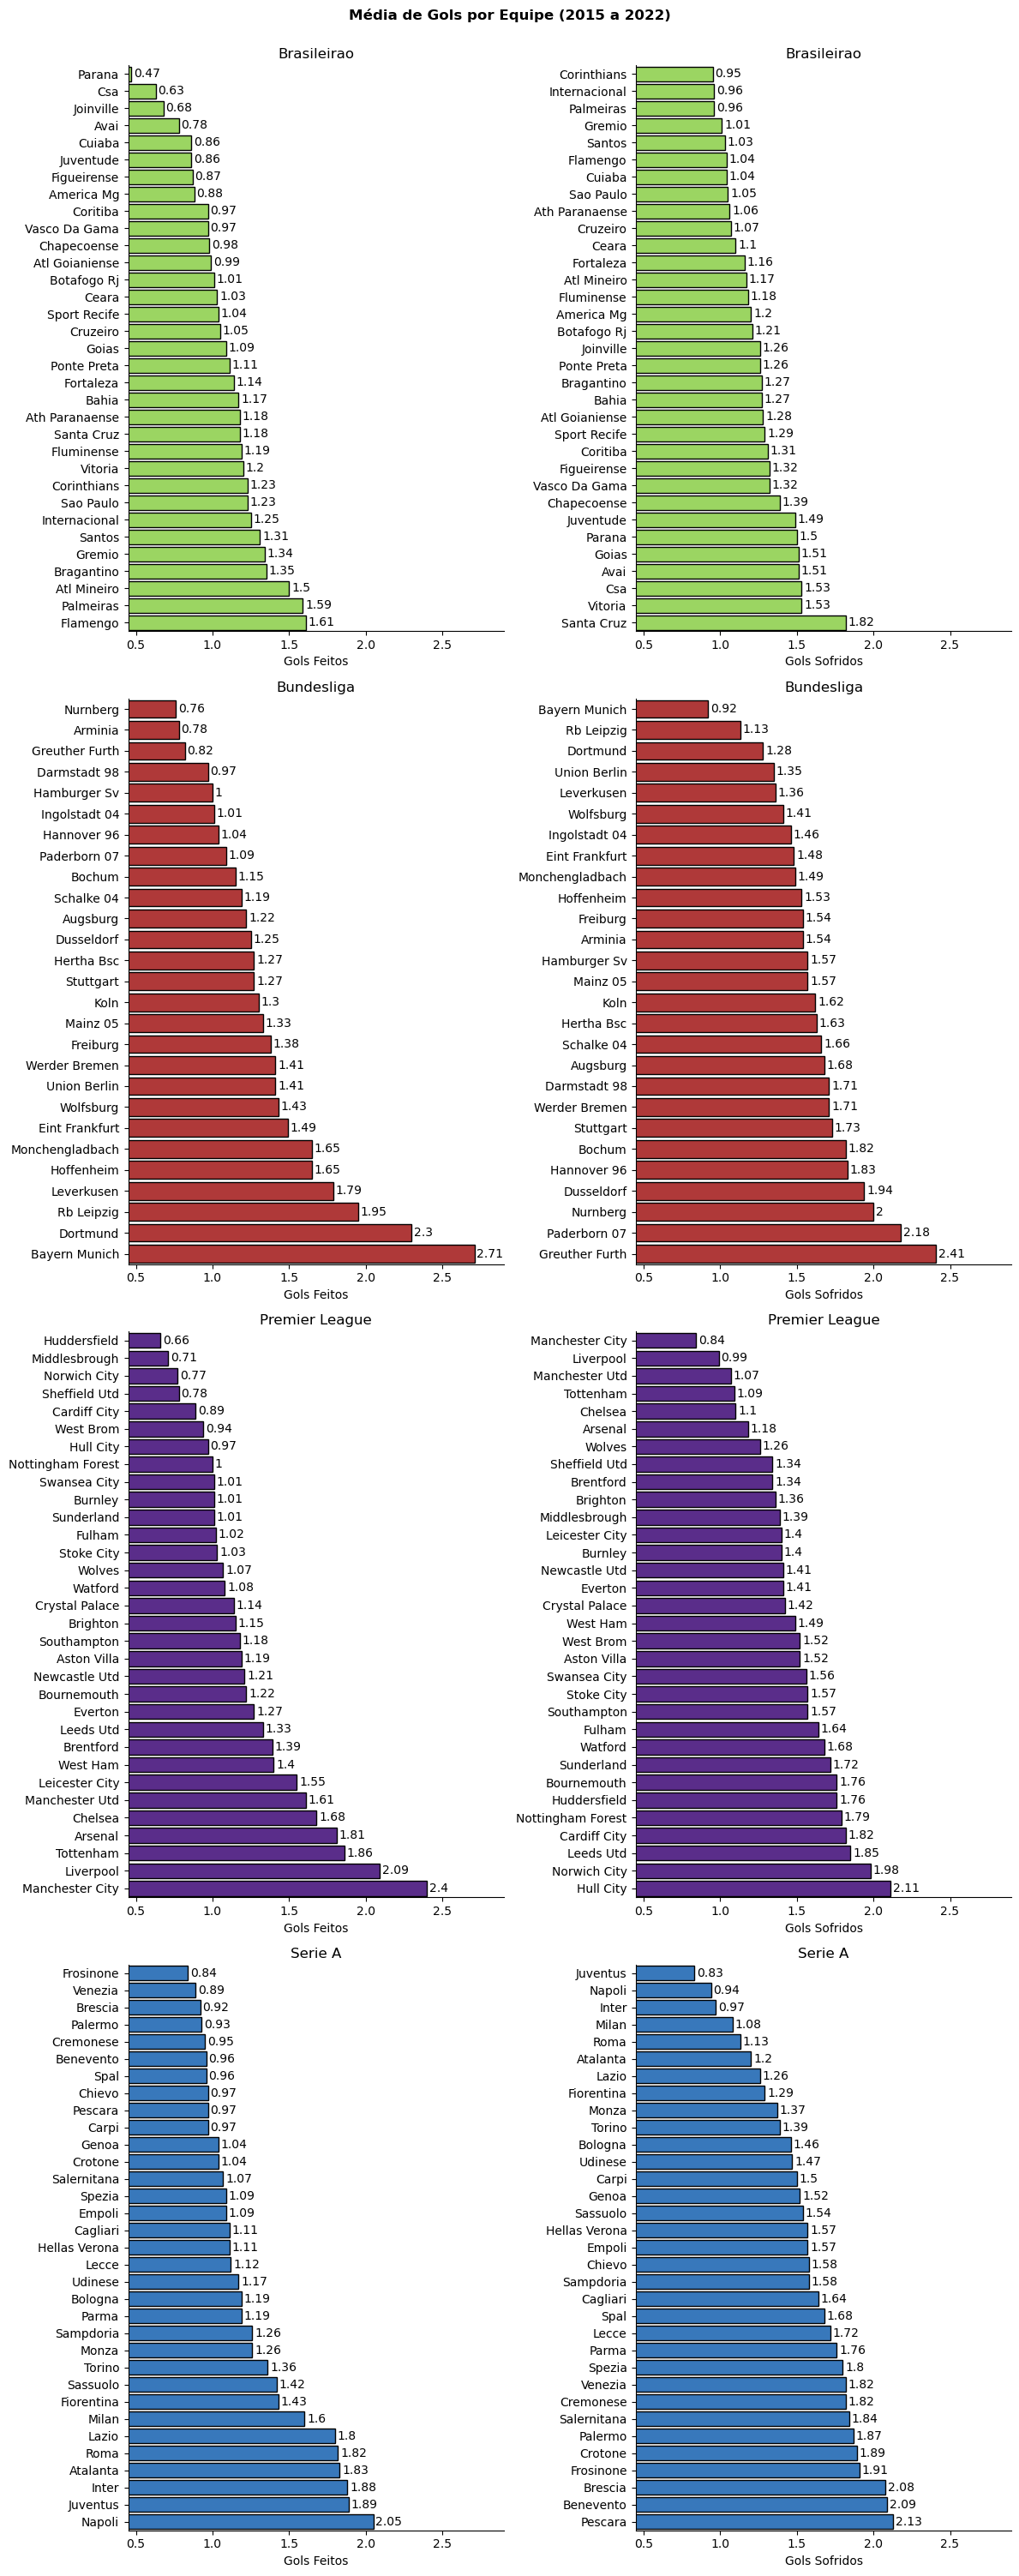

In [9]:
# Média de gols por time
gf_team = historico.groupby(['team', 'comp'])['gf'].aggregate('mean').reset_index().sort_values('gf').round(2)
gf_team['team'] = gf_team['team'].str.replace('_', ' ').str.title()
gf_team['g'] = gf_team['gf']

ga_team = historico.groupby(['team', 'comp'])['ga'].aggregate('mean').reset_index().sort_values('ga').round(2)
ga_team['team'] = ga_team['team'].str.replace('_', ' ').str.title()
ga_team['g'] = ga_team['ga']

gf = [gf_team, ga_team]


# Grafico
fig, axes = plt.subplots(4, 2, figsize= (12, 30))

for i, league in enumerate(gf_summary.index):
  for c, col in enumerate(gf):
    sns.barplot(col[col['comp'] == league], x= 'g', y= 'team', 
                errorbar= None, edgecolor= 'black', width= 0.85, color= colors_league[i], ax= axes[i, c])
    axes[i, c].bar_label(axes[i, c].containers[0], fontsize= 10, padding= 2)
    axes[i, c].set_xlim(0.45, 2.9)
    axes[i, c].tick_params(axis= 'y', direction='out', pad= 4)
    axes[i, c].set_ylabel('')
    axes[i, c].set_title(league)
    axes[i, c].spines['top'].set_visible(False)
    axes[i, c].spines['right'].set_visible(False)
    if c == 0:
      axes[i, c].set_xlabel('Gols Feitos')
    else:
      axes[i, c].set_xlabel('Gols Sofridos')

plt.suptitle("Média de Gols por Equipe (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/media_gols-liga.png')
plt.show()


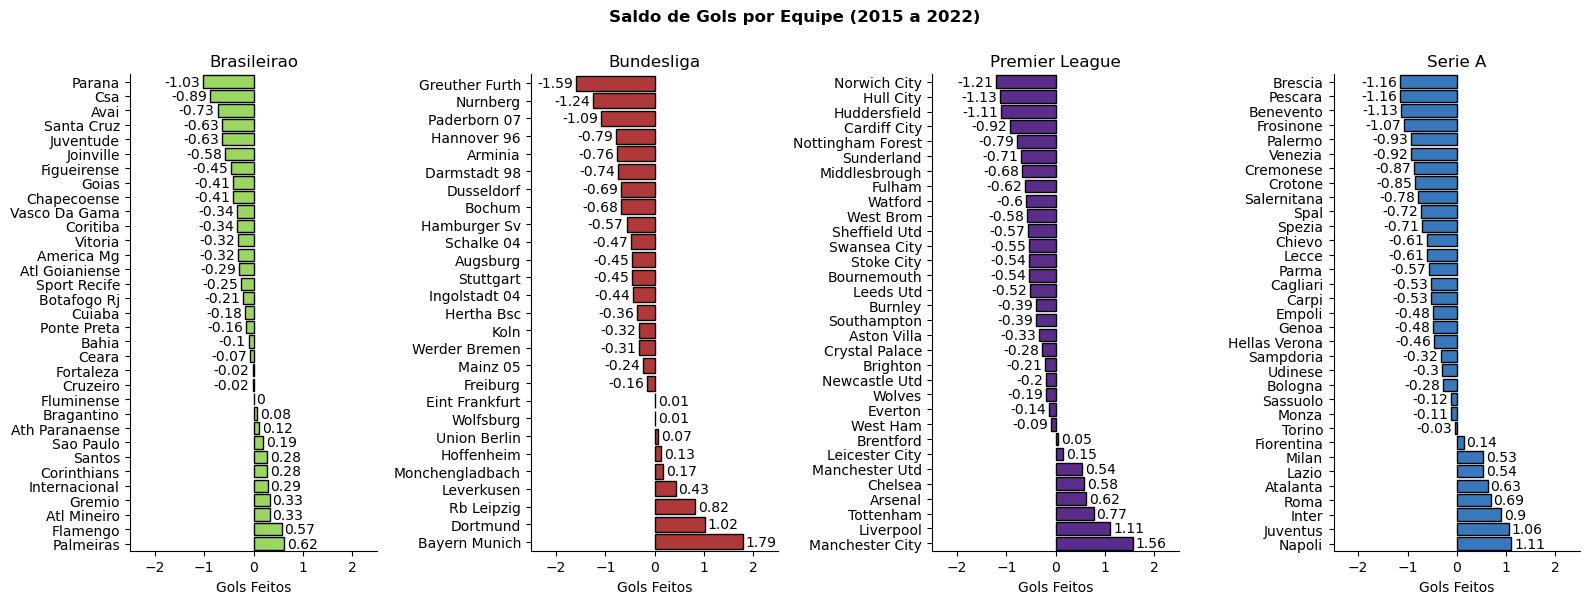

In [10]:
# Saldo de gols por time
historico['g_diff'] = historico['gf'] - historico['ga']
gd_team = historico.groupby(['team', 'comp'])['g_diff'].aggregate('mean').reset_index().sort_values('g_diff').round(2)
gd_team['team'] = gd_team['team'].str.replace('_', ' ').str.title()

# Grafico
fig, axes = plt.subplots(1, len(gf_summary.index), figsize= (16, 6))

for i, league in enumerate(gf_summary.index):
    sns.barplot(gd_team[gd_team['comp'] == league], x= 'g_diff', y= 'team', 
                errorbar= None, edgecolor= 'black', width= 0.85, color= colors_league[i], ax= axes[i])
    axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
    axes[i].set_xlim(-2.5, 2.5)
    axes[i].tick_params(axis= 'y', direction='out', pad= 4)
    axes[i].set_ylabel('')
    axes[i].set_title(league)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('Gols Feitos')

plt.suptitle("Saldo de Gols por Equipe (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/saldo_gols-liga.png')
plt.show()


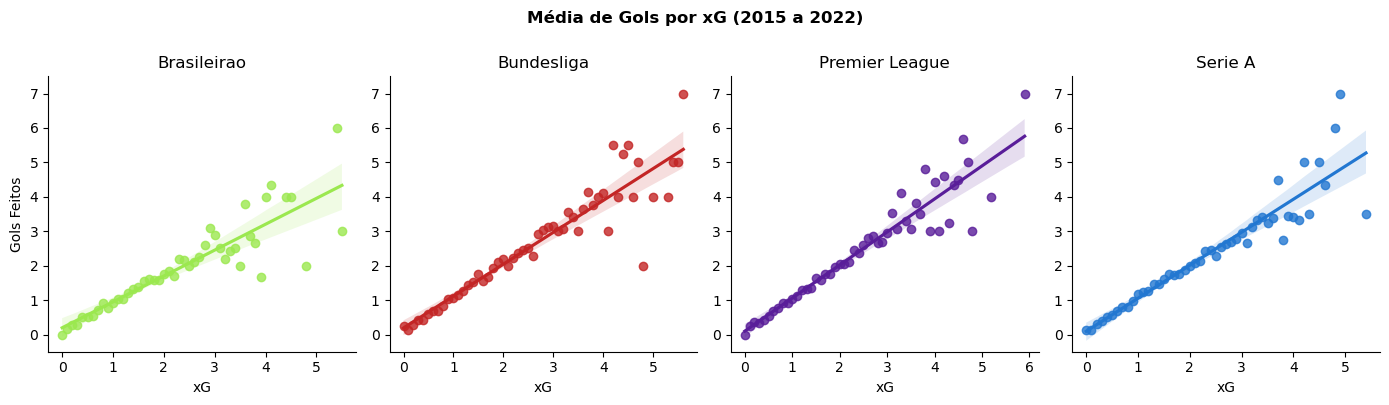

In [11]:
# Média de gols por xG
xg_gf = historico.groupby(['xg', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(xg_gf[xg_gf['comp'] == league], y= 'gf', x= 'xg', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.5, 7.5)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xG')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por xG (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/xg_gols-liga.png')
plt.show()


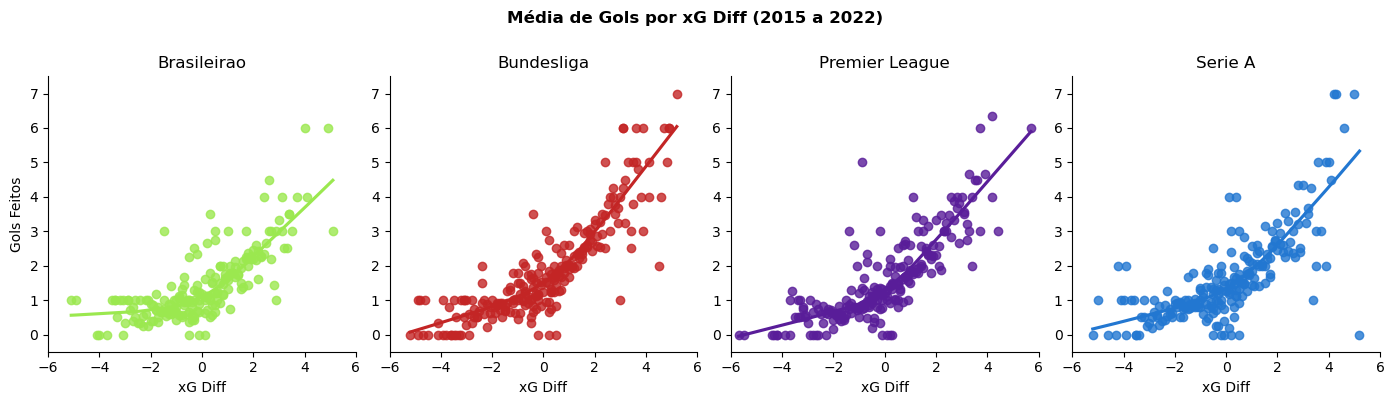

In [12]:
# Média do gols por xG Diff
historico['xg_diff'] = historico['xg'] - historico['xga']
xg_diff = historico.groupby(['xg_diff', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(xg_diff[xg_diff['comp'] == league], y= 'gf', x= 'xg_diff', lowess= True, color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.5, 7.5)
  axes[i].set_xlim(-6, 6)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xG Diff')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por xG Diff (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/xgdiff_gols-liga.png')
plt.show()


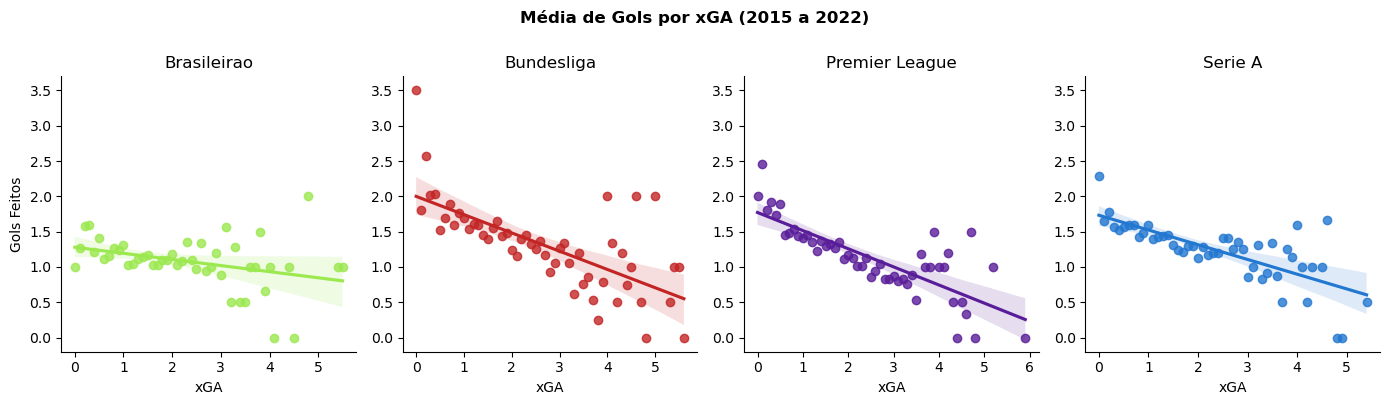

In [13]:
# Média de gols por xGA
xga_gf = historico.groupby(['xga', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(xga_gf[xga_gf['comp'] == league], y= 'gf', x= 'xga', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.2, 3.7)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xGA')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por xGA (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/xga_gols-liga.png')
plt.show()


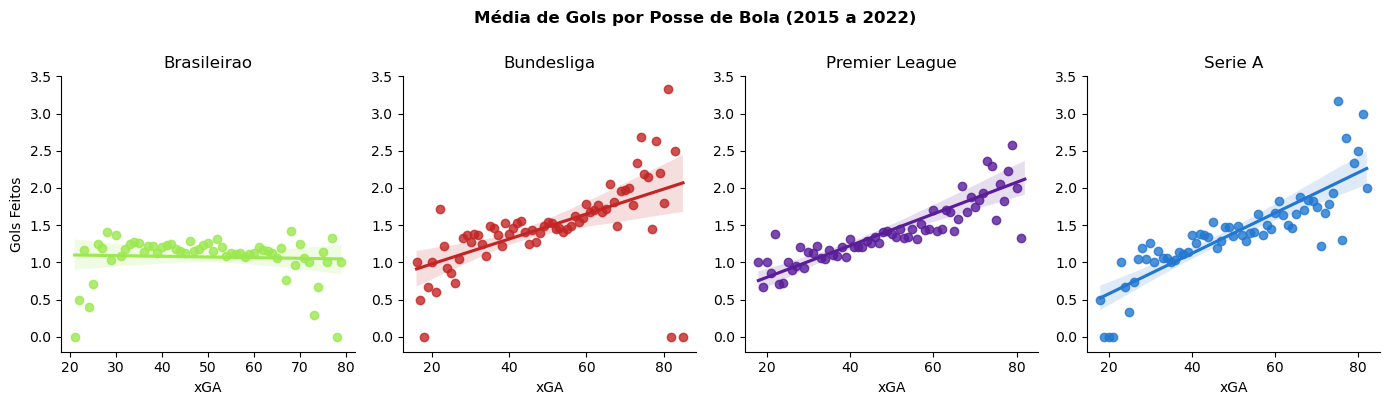

In [14]:
# Média de gols por Posse de bola
poss_gf = historico.groupby(['poss', 'comp'])['gf'].aggregate('mean').reset_index()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.regplot(poss_gf[poss_gf['comp'] == league], y= 'gf', x= 'poss', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(-0.2, 3.5)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('xGA')
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por Posse de Bola (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/poss_gols-liga.png')
plt.show()


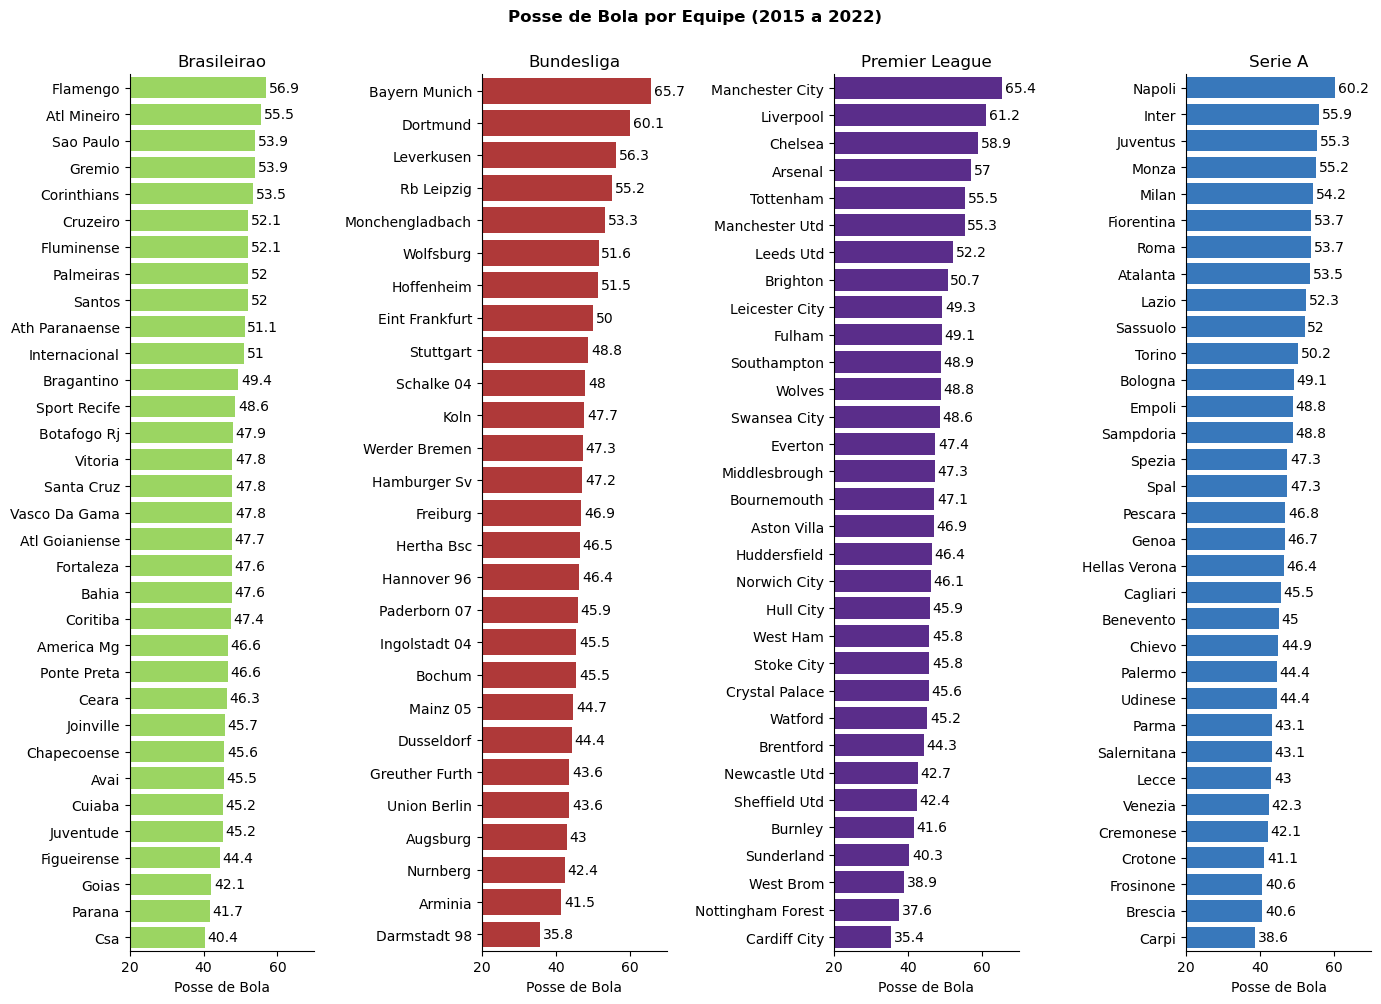

In [15]:
# Posse de bola por time
poss_team = historico.groupby(['comp', 'team'])['poss'].aggregate('mean').reset_index().sort_values(by= 'poss', ascending= False)
poss_team['poss'] = poss_team['poss'].round(1)
poss_team['team'] = poss_team['team'].str.replace('_', ' ').str.title()

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 10))

for i, league in enumerate(gf_summary.index):
  sns.barplot(poss_team[poss_team['comp'] == league], y= 'team', x= 'poss', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
  #axes[i].set_ylim(-0.2, 3.5)
  axes[i].set_xlim(20, 70)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('Posse de Bola')
  axes[i].set_ylabel('')

plt.suptitle("Posse de Bola por Equipe (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/poss_time-liga.png')
plt.show()


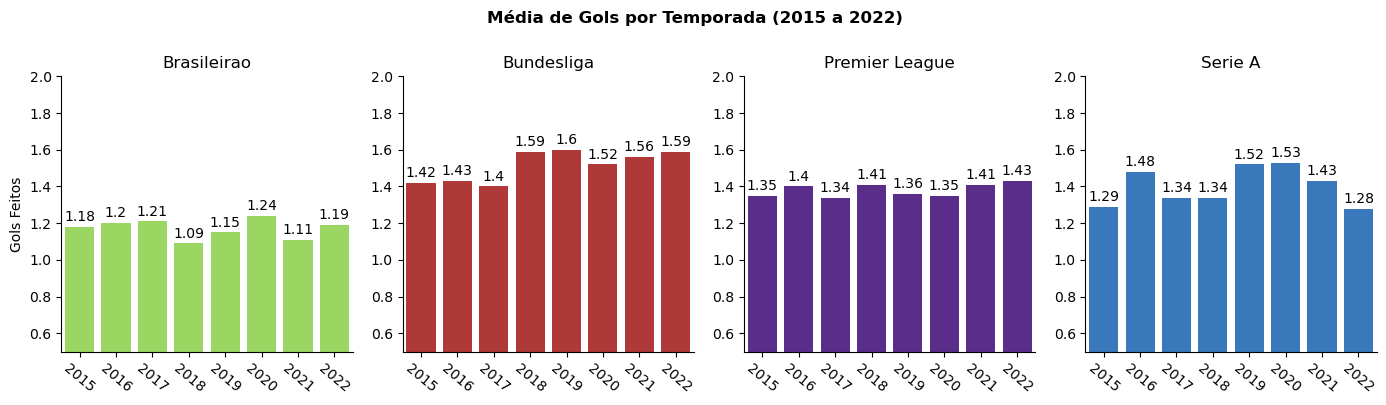

In [16]:
# Média de gols por Temporada
season_gf = historico.groupby(['season', 'comp'])['gf'].aggregate('mean').reset_index()
season_gf['gf'] = season_gf['gf'].round(2)

# Grafico
fig, axes = plt.subplots(1, 4, figsize= (14, 4))

for i, league in enumerate(gf_summary.index):
  sns.barplot(season_gf[season_gf['comp'] == league], y= 'gf', x= 'season', color= colors_league[i], ax= axes[i])
  axes[i].set_title(league)
  axes[i].set_ylim(0.5, 2)
  axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
  #axes[i].set_xlim(-0.5, 6.5)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  axes[i].set_xlabel('')
  axes[i].tick_params(axis='x', labelrotation = -40)
  if i > 0:
    axes[i].set_ylabel('')
  else:
    axes[i].set_ylabel('Gols Feitos')

plt.suptitle("Média de Gols por Temporada (2015 a 2022)", fontweight= 'bold', y= 1)
plt.tight_layout()
plt.savefig('figures/analysis/mean_gols-liga.png')
plt.show()


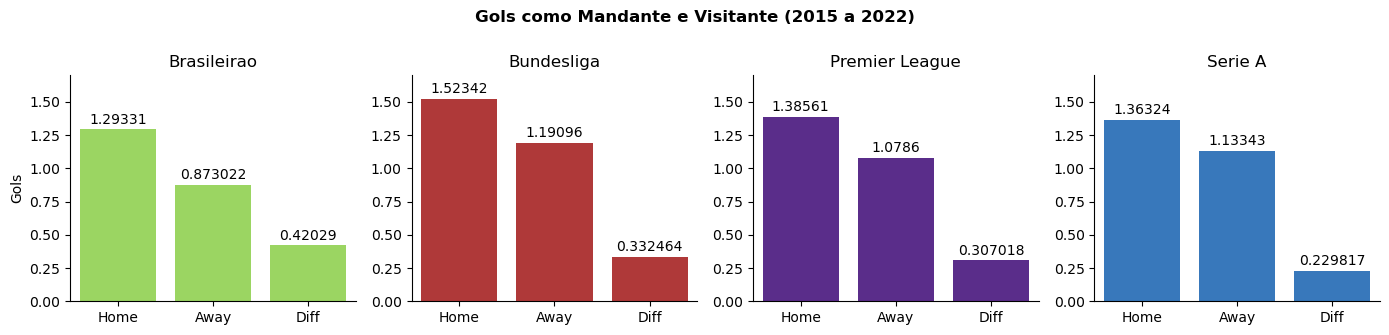

In [17]:
# Gols como mandante ou visitante por liga
venue_df = historico.groupby(['team', 'comp', 'venue'])['gf'].aggregate('mean').reset_index()
venue1_df = venue_df.pivot(index= ['team', 'comp'], columns= 'venue', values= 'gf')
venue1_df['Diff'] = venue1_df['Home'] - venue1_df['Away']
venue1_df = venue1_df.reset_index()
venue1_df = venue1_df.melt(id_vars= ['comp', 'team'], value_vars = ['Home', 'Away', 'Diff'])

# Gráfico de barras
fig, axes = plt.subplots(1, 4, figsize= (14, 3))

for i, league in enumerate(gf_summary.index):
  sns.barplot(venue1_df[venue1_df['comp'] == league], x= 'venue', y= 'value', ax= axes[i], color= colors_league[i], errorbar= None)
  axes[i].set_xlabel('')
  axes[i].bar_label(axes[i].containers[0], fontsize= 10, padding= 2)
  axes[i].set_ylim(0, 1.7)
  axes[i].set_title(league)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  if i == 0:
    axes[i].set_ylabel('Gols')
  else:
    axes[i].set_ylabel('')
  
plt.tight_layout()
plt.suptitle('Gols como Mandante e Visitante (2015 a 2022)', fontweight= 'bold', y= 1.1)
plt.savefig('figures/analysis/mandante_gols-ligas.png')
plt.show()

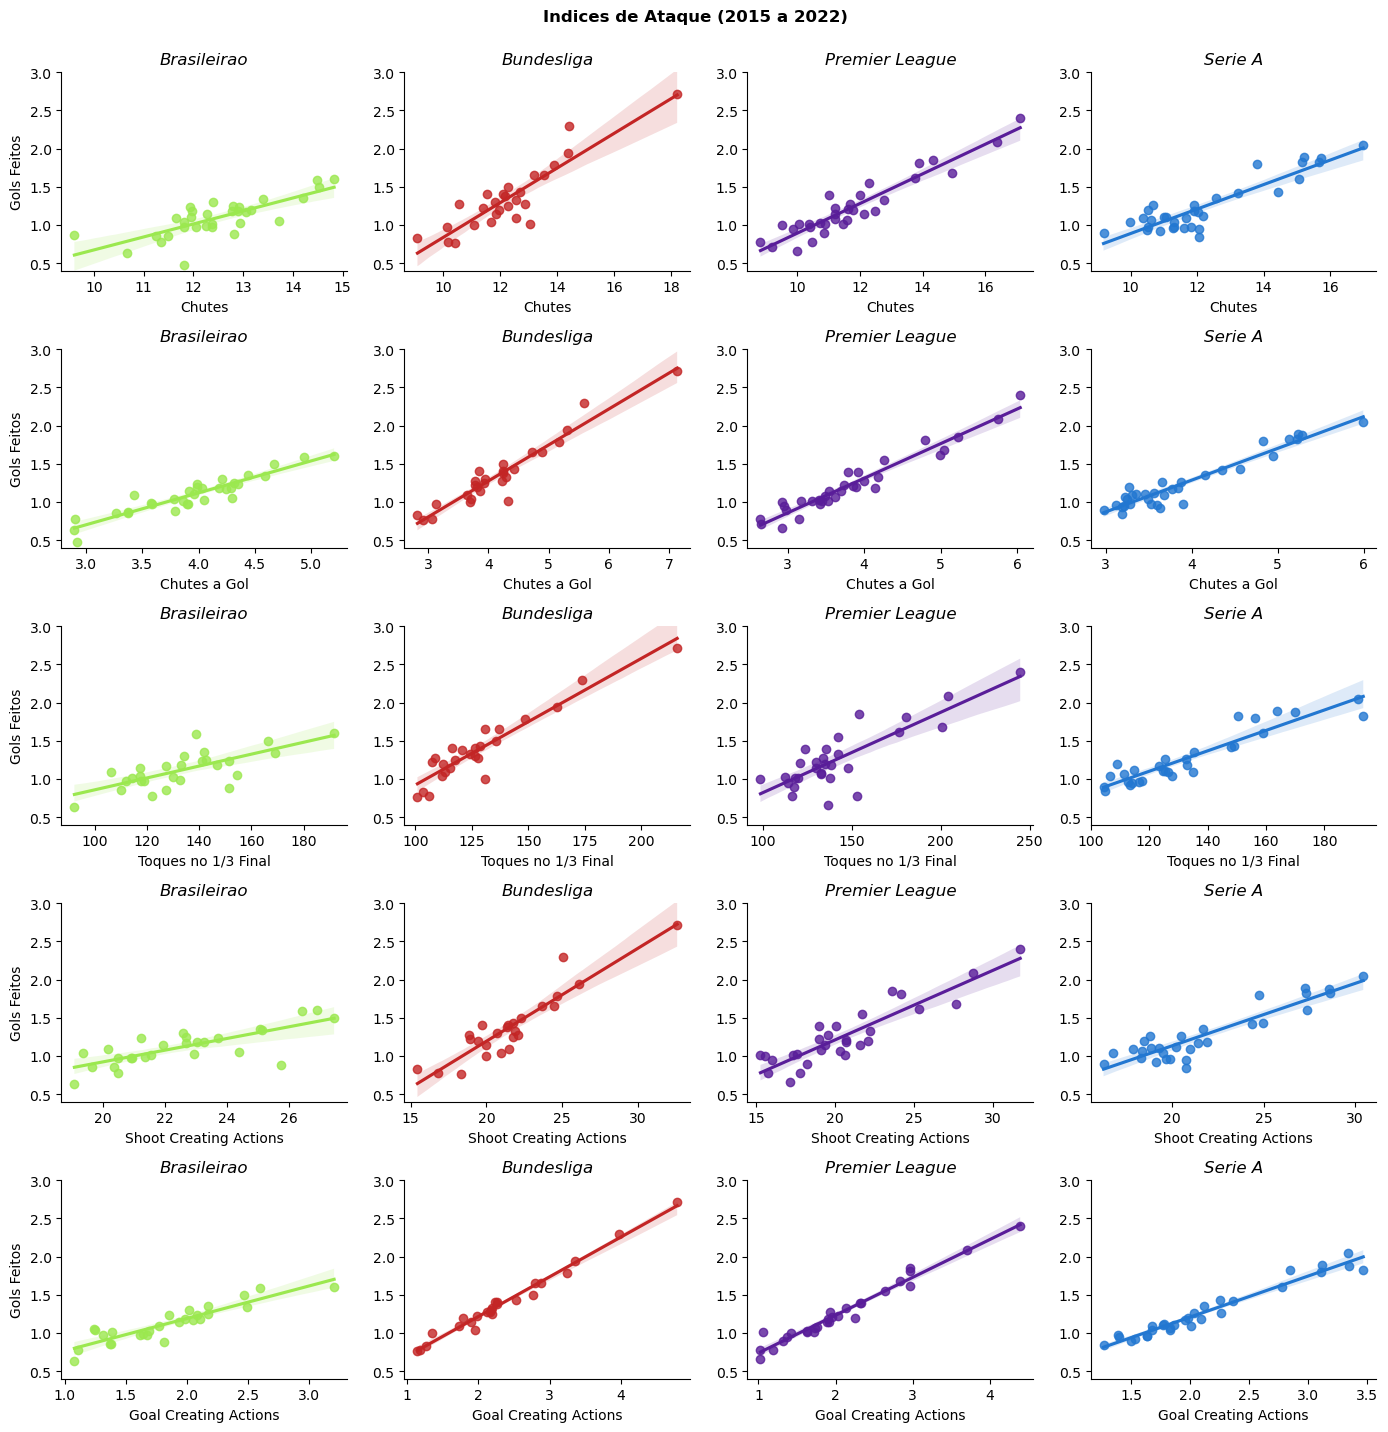

In [18]:
# Indices de Ataque
attck = historico.groupby(['comp', 'team'])[['sh', 'sot', 'touches_att_3rd', 'sca', 'gca', 'gf']].aggregate('mean').reset_index()

# Graficos
fig, axes = plt.subplots(5, 4, figsize= (14, 14))
for i, league in enumerate(gf_summary.index):
  sns.regplot(attck[attck['comp'] == league], x= 'sh', y= 'gf', ax= axes[0, i], color= colors_league[i])
  sns.regplot(attck[attck['comp'] == league], x= 'sot', y= 'gf', ax= axes[1, i], color= colors_league[i])
  sns.regplot(attck[attck['comp'] == league], x= 'touches_att_3rd', y= 'gf', ax= axes[2, i], color= colors_league[i])
  sns.regplot(attck[attck['comp'] == league], x= 'sca', y= 'gf', ax= axes[3, i], color= colors_league[i])
  sns.regplot(attck[attck['comp'] == league], x= 'gca', y= 'gf', ax= axes[4, i], color= colors_league[i])
  axes[0, i].set_xlabel('Chutes')
  axes[1, i].set_xlabel('Chutes a Gol')
  axes[2, i].set_xlabel('Toques no 1/3 Final')
  axes[3, i].set_xlabel('Shoot Creating Actions')
  axes[4, i].set_xlabel('Goal Creating Actions')
  for j in range(5):
    axes[j, 0].set_ylabel('Gols Feitos')
    axes[j, i].set_ylim(0.4, 3)
    axes[j, i].set_title(league, fontstyle= 'italic')
    axes[j, i].spines['top'].set_visible(False)
    axes[j, i].spines['right'].set_visible(False)
    if i != 0:
      axes[j, i].set_ylabel('')

plt.tight_layout()
fig.suptitle('Indices de Ataque (2015 a 2022)', y= 1.02, fontweight= 'bold')
plt.savefig('figures/analysis/indicesatt-ligas.png')
plt.show()

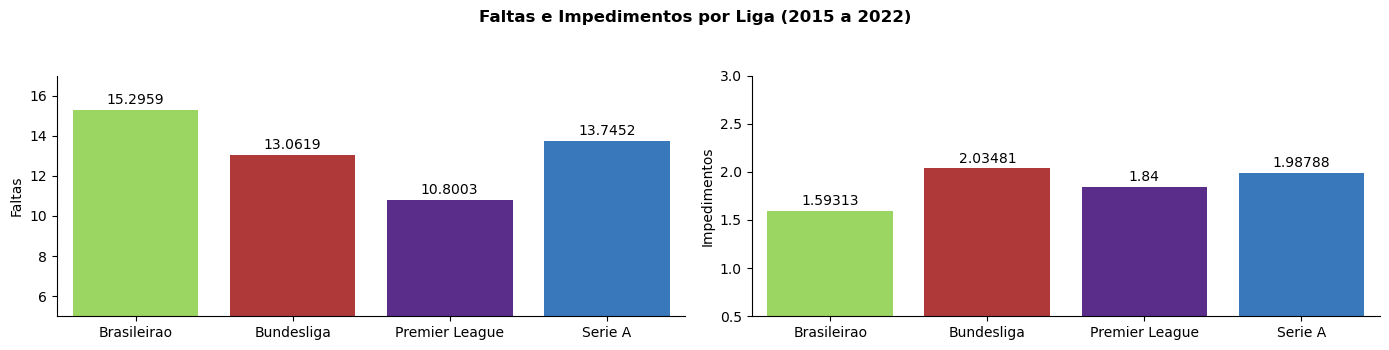

In [19]:
# Faltas, Impedimento, Recuperacao de Bola
misc = historico.groupby(['team', 'comp'])[['fls', 'off']].aggregate('mean').reset_index()
misc['fls'] = misc['fls'].round(2)
misc['off'] = misc['off'].round(2)
misc_y = ['fls', 'off']

# Cores
colors_palette = sns.color_palette(colors_league)

# Graficos
fig, axes = plt.subplots(1, 2, figsize= (14, 3))
for i in range(2):
  sns.barplot(misc, x= 'comp', y= misc_y[i], ax= axes[i], hue= 'comp', palette= colors_palette, errorbar= None)
  axes[i].set_xlabel('')
  axes[0].set_ylabel('Faltas')
  axes[1].set_ylabel('Impedimentos')
  axes[0].set_ylim(5, 17)
  axes[1].set_ylim(0.5, 3)
  axes[i].spines['top'].set_visible(False)
  axes[i].spines['right'].set_visible(False)
  for j in range(4):
    axes[i].bar_label(axes[i].containers[j], fontsize= 10, padding= 2)
  #  if i != 0:
  #    axes[j, i].set_ylabel('')

plt.tight_layout()
fig.suptitle('Faltas e Impedimentos por Liga (2015 a 2022)', y= 1.15, fontweight= 'bold')
plt.savefig('figures/analysis/misc-ligas.png')
plt.show()

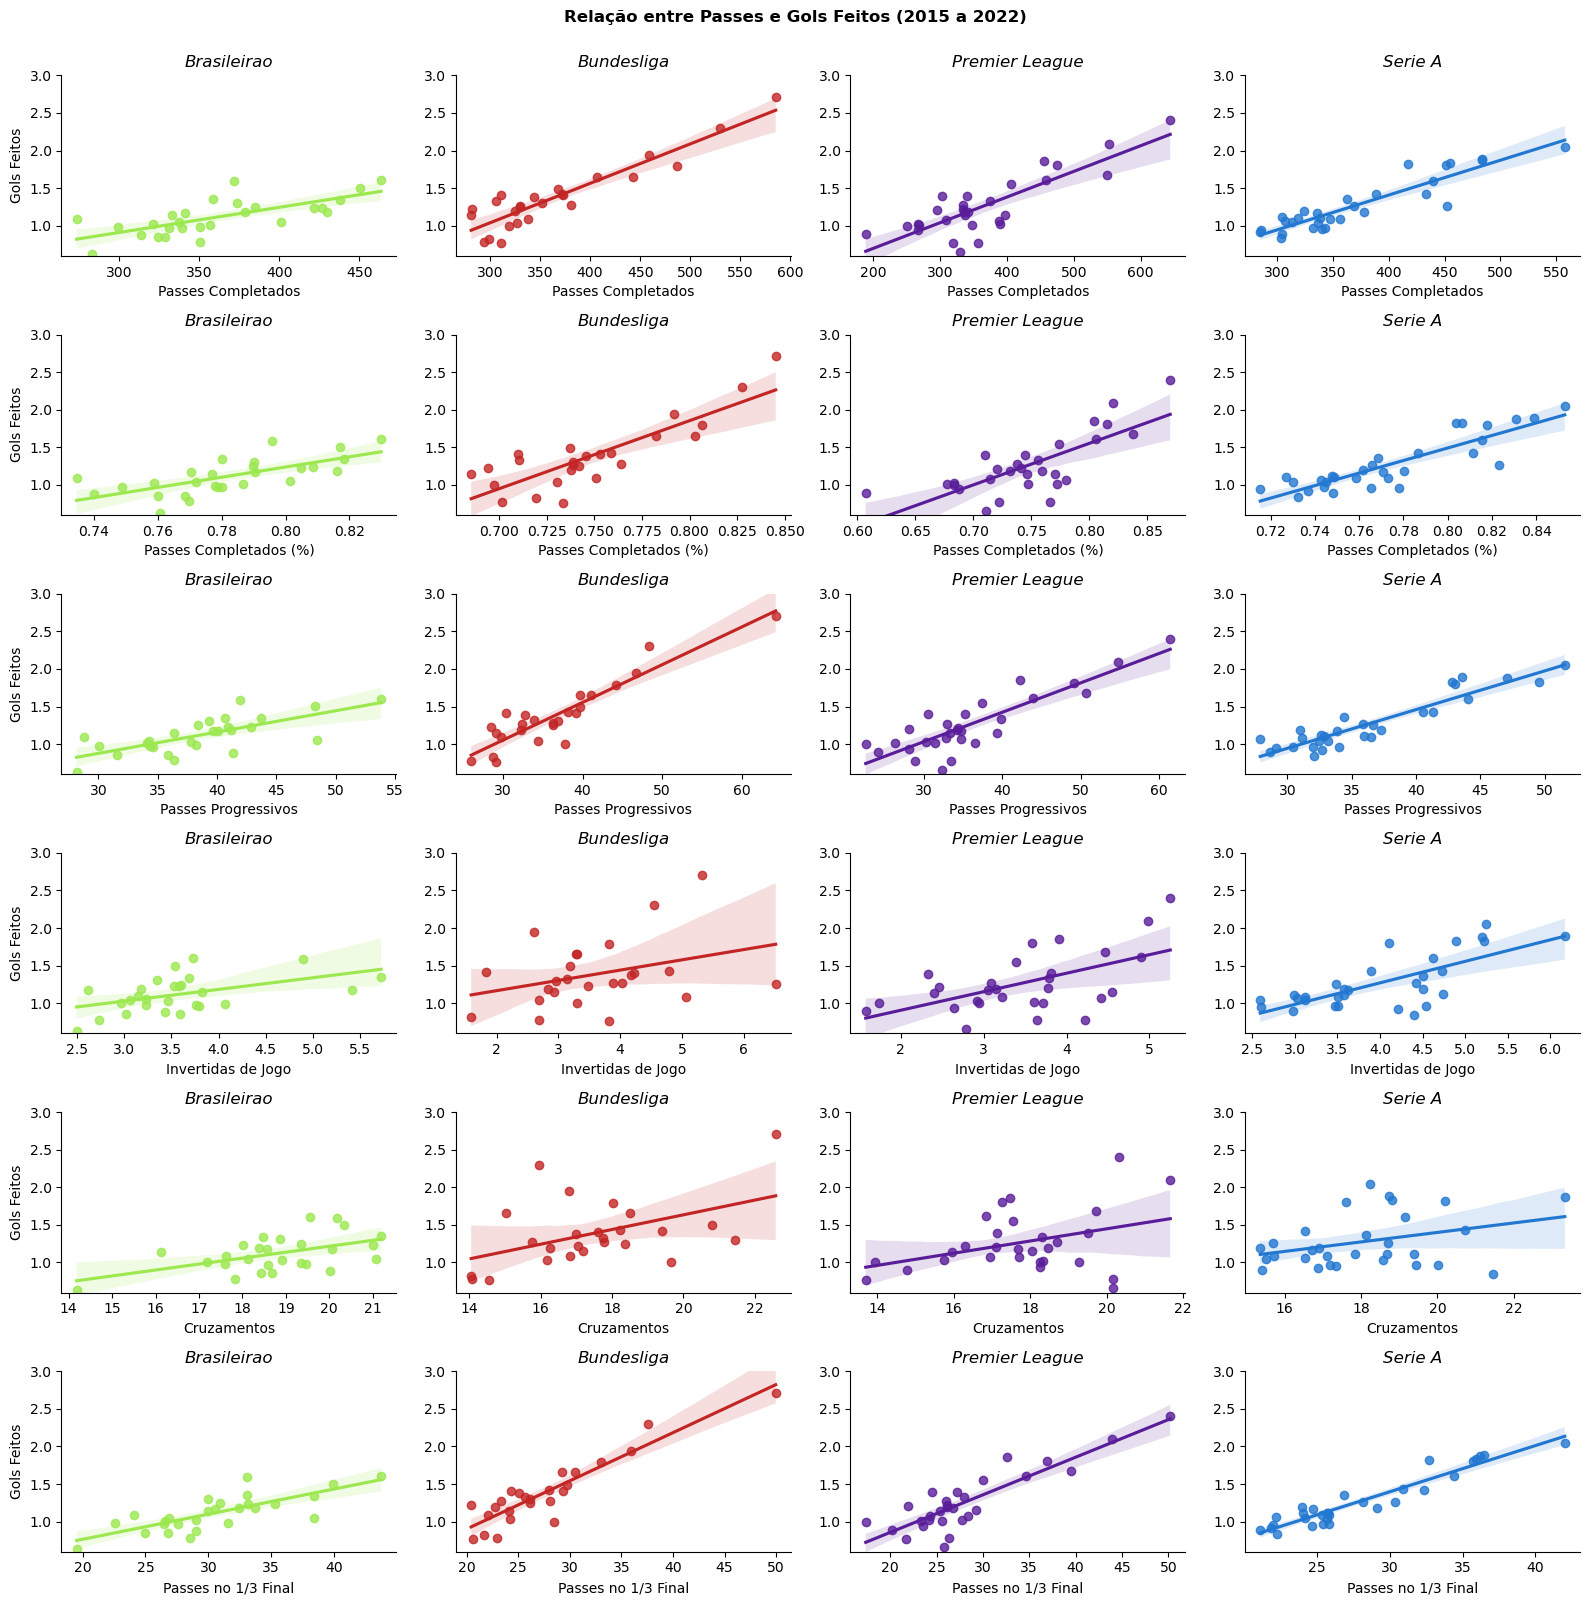

In [20]:
# Tipos de passes e gols
historico['cmp%'] = historico['cmp']/historico['att']
passes = historico.groupby(['team', 'comp'])[['gf', 'cmp', 'cmp%', 'prgp', 'sw', 'crs', 'pass_3rd']].aggregate('mean').reset_index()
passes_y = ['cmp', 'cmp%', 'prgp', 'sw', 'crs', 'pass_3rd']


# Gráfico
fig, axes = plt.subplots(6, 4, figsize= (16, 16))

for i, league in enumerate(gf_summary.index):
  for j in range(6):
    sns.regplot(passes[passes['comp'] == league], x= passes_y[j], y= 'gf', ax= axes[j, i], color= colors_league[i])
    axes[j, i].spines['top'].set_visible(False)
    axes[j, i].spines['right'].set_visible(False)
    axes[j, i].set_title(league, fontstyle= 'italic')
    axes[j, i].set_ylim(0.6, 3)
    axes[0, i].set_xlabel('Passes Completados')
    axes[1, i].set_xlabel('Passes Completados (%)')
    axes[2, i].set_xlabel('Passes Progressivos')
    axes[3, i].set_xlabel('Invertidas de Jogo')
    axes[4, i].set_xlabel('Cruzamentos')
    axes[5, i].set_xlabel('Passes no 1/3 Final')
    if i != 0:
      axes[j, i].set_ylabel('')
    else:
      axes[j, i].set_ylabel('Gols Feitos')
      
plt.suptitle('Relação entre Passes e Gols Feitos (2015 a 2022)', y= 1, fontweight= 'bold')
plt.savefig('figures/analysis/passes_gols-ligas.png')
plt.tight_layout()
plt.show()

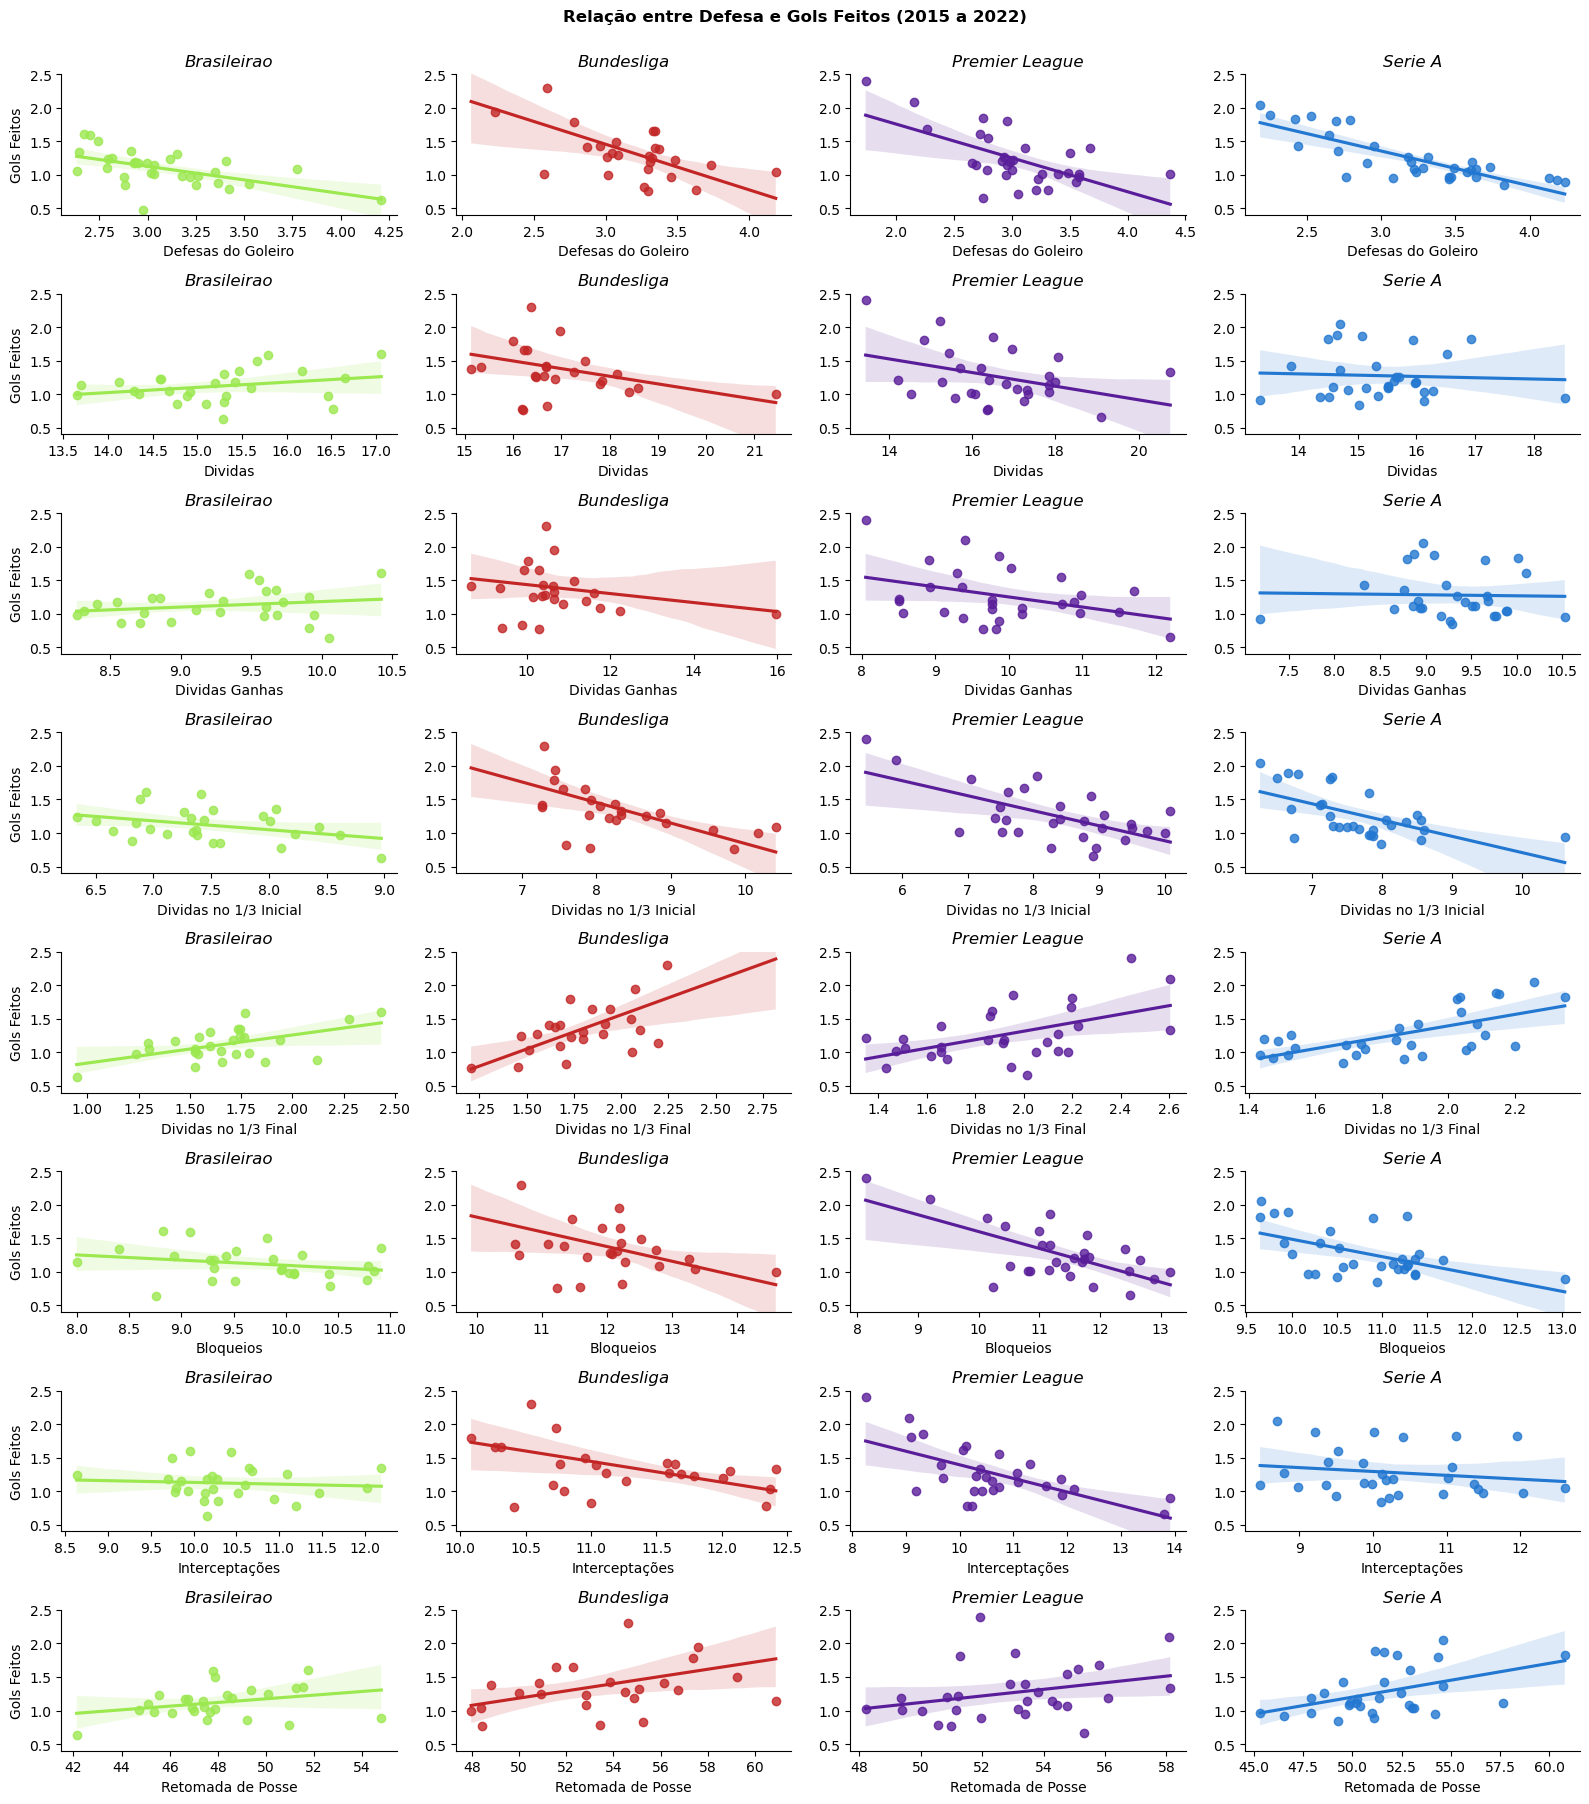

In [21]:
# Defesa e gols Feitos
def_df = historico.groupby(['team', 'comp'])[['gf', 'ga', 'saves', 'tkl', 'tklw', 'tkl_def_3rd', 'tkl_att_3rd', 'blocks', 'int', 'recov']].aggregate('mean').reset_index()
def_list = ['saves', 'tkl', 'tklw', 'tkl_def_3rd', 'tkl_att_3rd', 'blocks', 'int', 'recov']


# Gráfico
fig, axes = plt.subplots(8, 4, figsize= (16, 18))

for i, league in enumerate(gf_summary.index):
  for j in range(8):
    sns.regplot(def_df[def_df['comp'] == league], x= def_list[j], y= 'gf', ax= axes[j, i], color= colors_league[i])
    axes[j, i].spines['top'].set_visible(False)
    axes[j, i].spines['right'].set_visible(False)
    axes[j, i].set_title(league, fontstyle= 'italic')
    axes[j, i].set_ylim(0.4, 2.5)
    axes[0, i].set_xlabel('Defesas do Goleiro')
    axes[1, i].set_xlabel('Dividas')
    axes[2, i].set_xlabel('Dividas Ganhas')
    axes[3, i].set_xlabel('Dividas no 1/3 Inicial')
    axes[4, i].set_xlabel('Dividas no 1/3 Final')
    axes[5, i].set_xlabel('Bloqueios')
    axes[6, i].set_xlabel('Interceptações')
    axes[7, i].set_xlabel('Retomada de Posse')
    if i != 0:
      axes[j, i].set_ylabel('')
    else:
      axes[j, i].set_ylabel('Gols Feitos')
      
plt.suptitle('Relação entre Defesa e Gols Feitos (2015 a 2022)', y= 1, fontweight= 'bold')
plt.savefig('figures/analysis/defesa_golsmade-ligas.png')
plt.tight_layout()
plt.show()

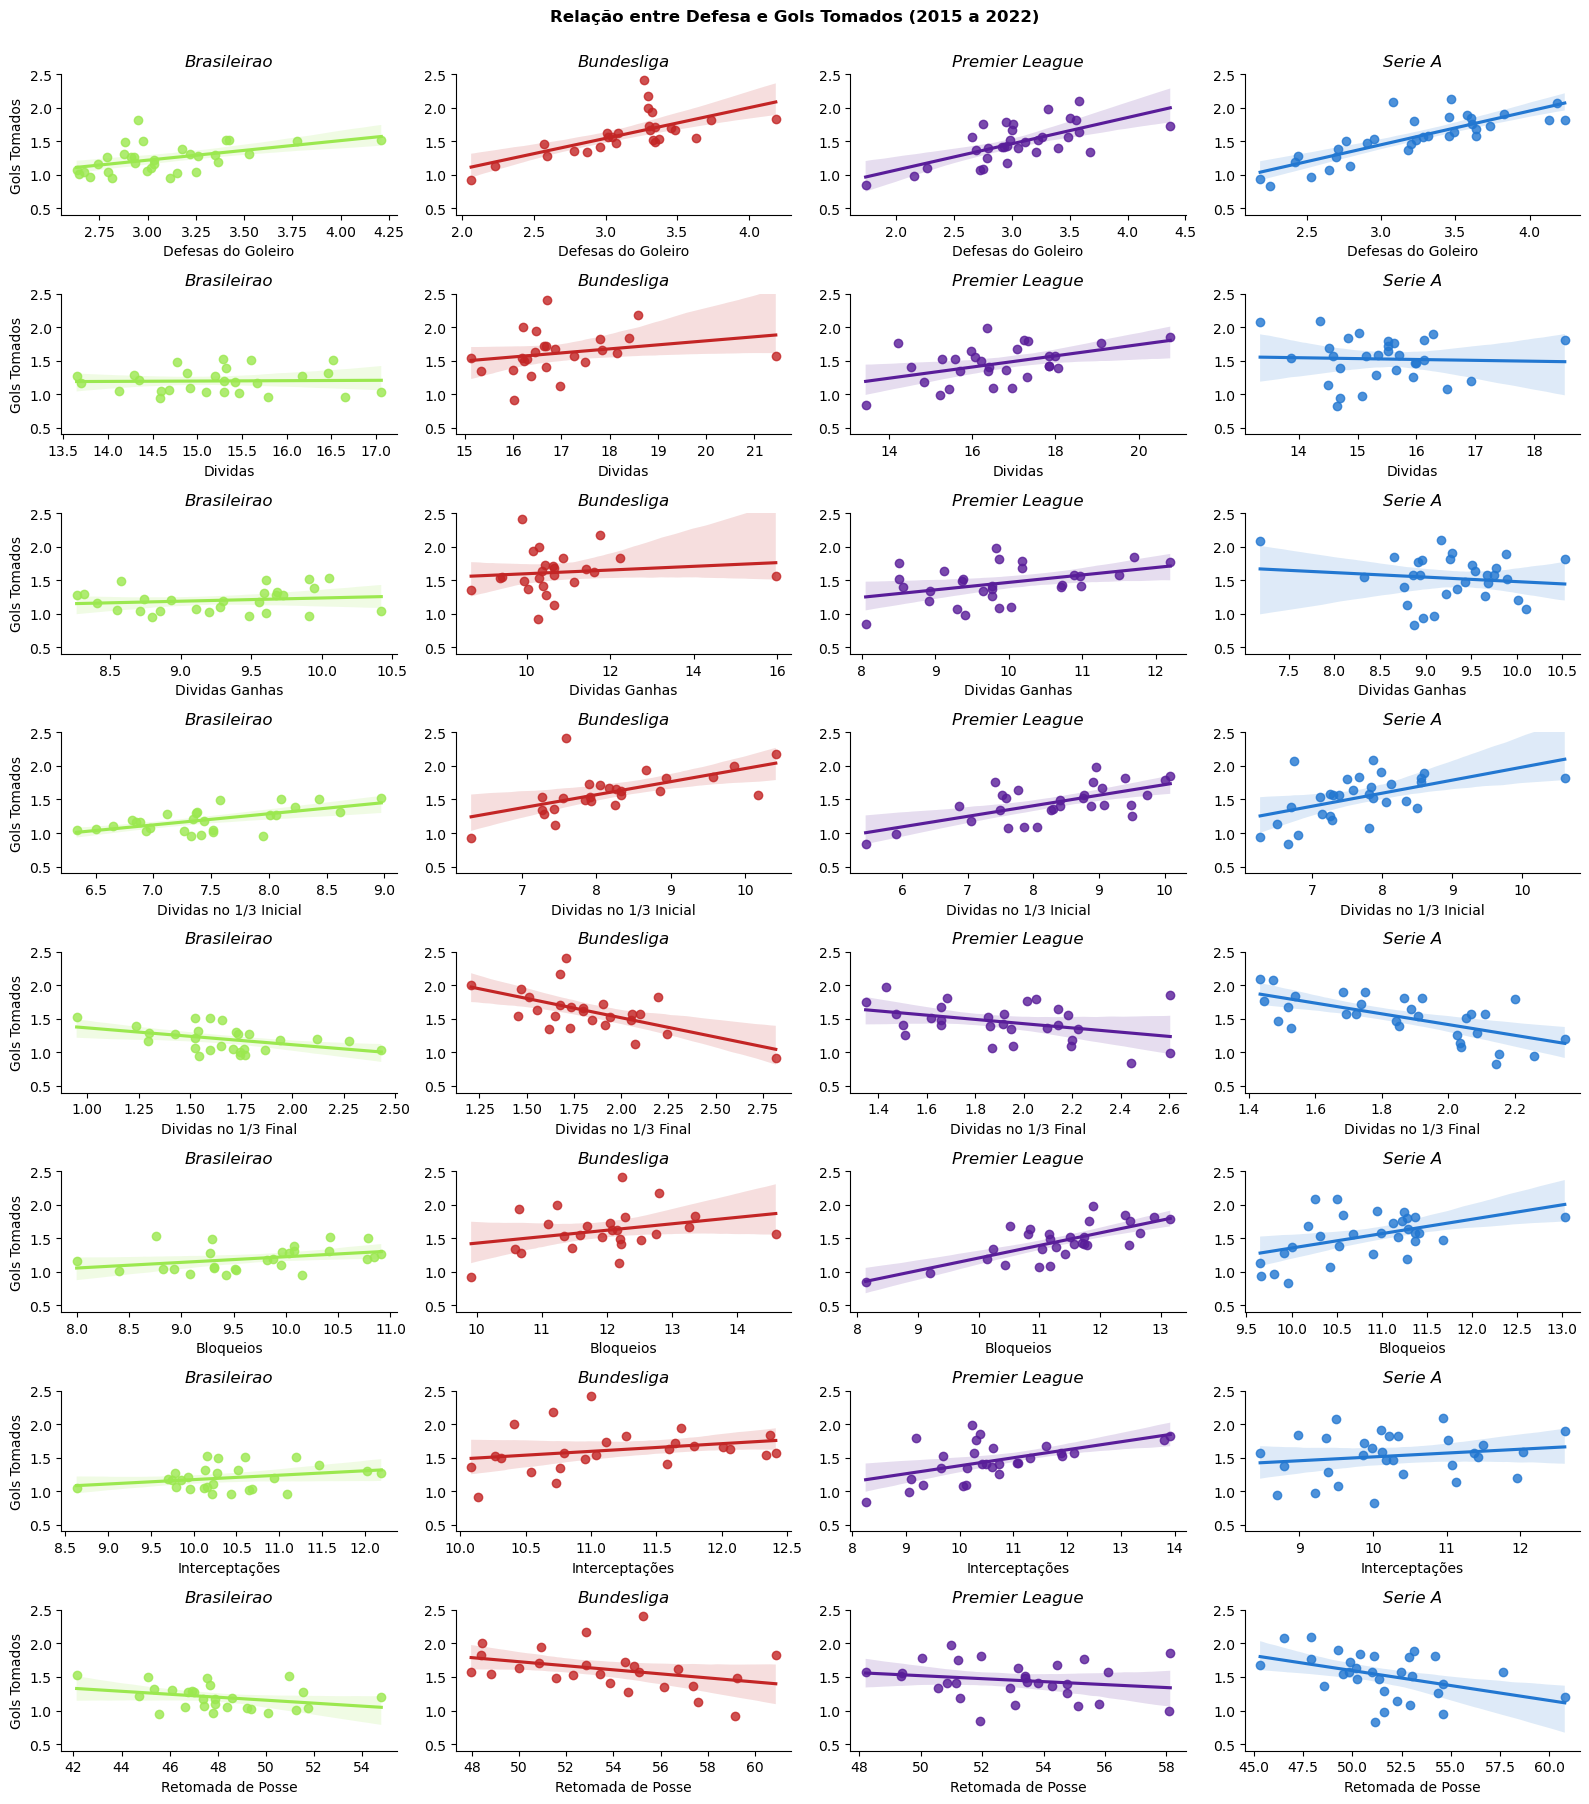

In [22]:
# Defesa e gols tomados
fig, axes = plt.subplots(8, 4, figsize= (16, 18))

for i, league in enumerate(gf_summary.index):
  for j in range(8):
    sns.regplot(def_df[def_df['comp'] == league], x= def_list[j], y= 'ga', ax= axes[j, i], color= colors_league[i])
    axes[j, i].spines['top'].set_visible(False)
    axes[j, i].spines['right'].set_visible(False)
    axes[j, i].set_title(league, fontstyle= 'italic')
    axes[j, i].set_ylim(0.4, 2.5)
    axes[0, i].set_xlabel('Defesas do Goleiro')
    axes[1, i].set_xlabel('Dividas')
    axes[2, i].set_xlabel('Dividas Ganhas')
    axes[3, i].set_xlabel('Dividas no 1/3 Inicial')
    axes[4, i].set_xlabel('Dividas no 1/3 Final')
    axes[5, i].set_xlabel('Bloqueios')
    axes[6, i].set_xlabel('Interceptações')
    axes[7, i].set_xlabel('Retomada de Posse')
    if i != 0:
      axes[j, i].set_ylabel('')
    else:
      axes[j, i].set_ylabel('Gols Tomados')
      
plt.suptitle('Relação entre Defesa e Gols Tomados (2015 a 2022)', y= 1, fontweight= 'bold')
plt.savefig('figures/analysis/defesa_golsagainst-ligas.png')
plt.tight_layout()
plt.show()